In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [109]:
from scipy.stats import skew, boxcox, boxcox_normmax

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn_pandas import DataFrameMapper, gen_features

from scipy.cluster.hierarchy import linkage, dendrogram

In [96]:
from scipy.stats import boxcox, boxcox_normmax


class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    '''box-cox transformation for skewed distribution'''
    
    def fit(self, X, y=None):
        
        # if min = 0 add 1 to all values
        self.shift_ = 1 
        _, self.lambda_ = boxcox(X + self.shift_)
        
        return self
    
    def transform(self, X):
        
        return boxcox(X + self.shift_, lmbda=self.lambda_)

### Ex 3.1

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"

cols = "RI Na Mg Al Si K Ca Ba Fe Type".split()
glass = pd.read_csv(url, header=None, index_col=0, names=cols)
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
glass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 28.4 KB


In [11]:
glass.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


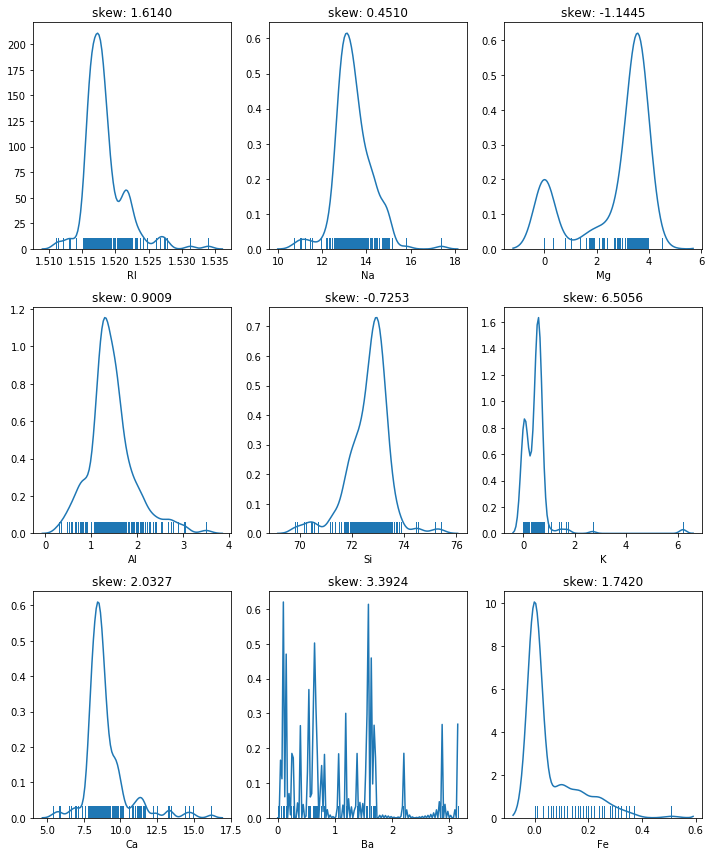

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 12))

for c, axi in zip(glass.columns[:-1], ax.flat):
    sns.distplot(glass[c], hist=False, kde=True, rug=True, ax=axi)
    axi.set_title("skew: {:.4f}".format(skew(glass[c].values)))

fig.tight_layout()

In [15]:
data = glass.iloc[:, :-1]
data.shape

(214, 9)

In [19]:
data_skew = pd.Series(skew(data.values), index=data.columns)
data_skew

RI    1.614015
Na    0.450992
Mg   -1.144465
Al    0.900918
Si   -0.725317
K     6.505636
Ca    2.032677
Ba    3.392431
Fe    1.742007
dtype: float64

In [97]:
boxcox_transfrom = DataFrameMapper(gen_features(data.columns[1:], classes=[BoxCoxTransformer]), default=None, 
                                   df_out=True, input_df=True)


In [98]:
data_boxcox = boxcox_transfrom.fit_transform(data)

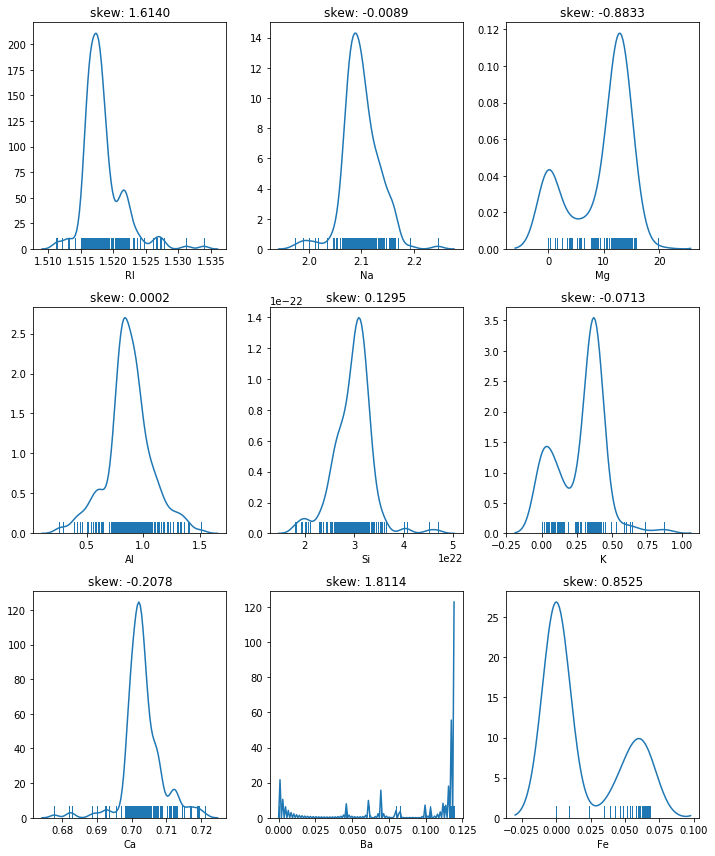

In [99]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 12))
for c, axi in zip(data.columns, ax.flat):
    sns.distplot(data_boxcox[c], hist=False, kde=True, rug=True, ax=axi)
    axi.set_title("skew: {:.4f}".format(skew(data_boxcox[c])))
    
fig.tight_layout()

In [100]:
pd.Series(skew(data_boxcox.values), index=data_boxcox.columns)

Na   -0.008910
Mg   -0.883281
Al    0.000217
Si    0.129468
K    -0.071312
Ca   -0.207843
Ba    1.811363
Fe    0.852478
RI    1.614015
dtype: float64

In [101]:
_, l = boxcox(data.Si)
l

12.468390860704869

In [103]:
_, l = boxcox(data.Si +100)
l

28.038218072203126

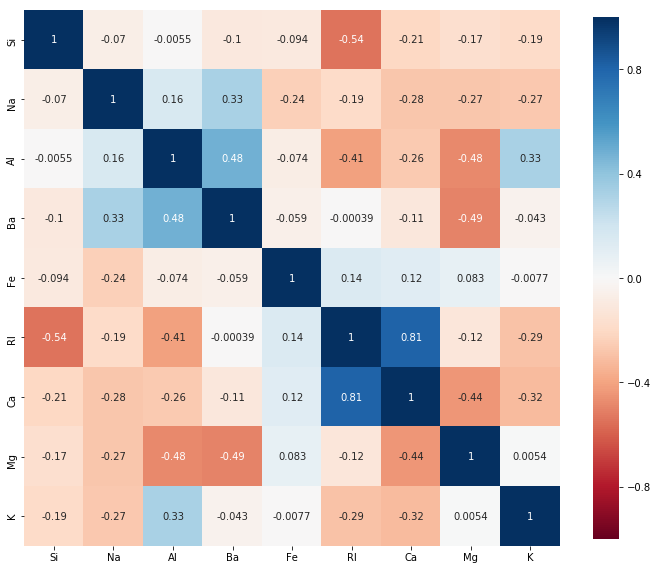

In [110]:
corr = data.corr()

Y = linkage(corr, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']
corr = corr.iloc[:, Z]
corr = corr.iloc[Z, :]

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, annot=True, square=True, ax=ax, cbar_kws={'shrink': .8}, vmin=-1, vmax=1, cmap=plt.cm.RdBu)

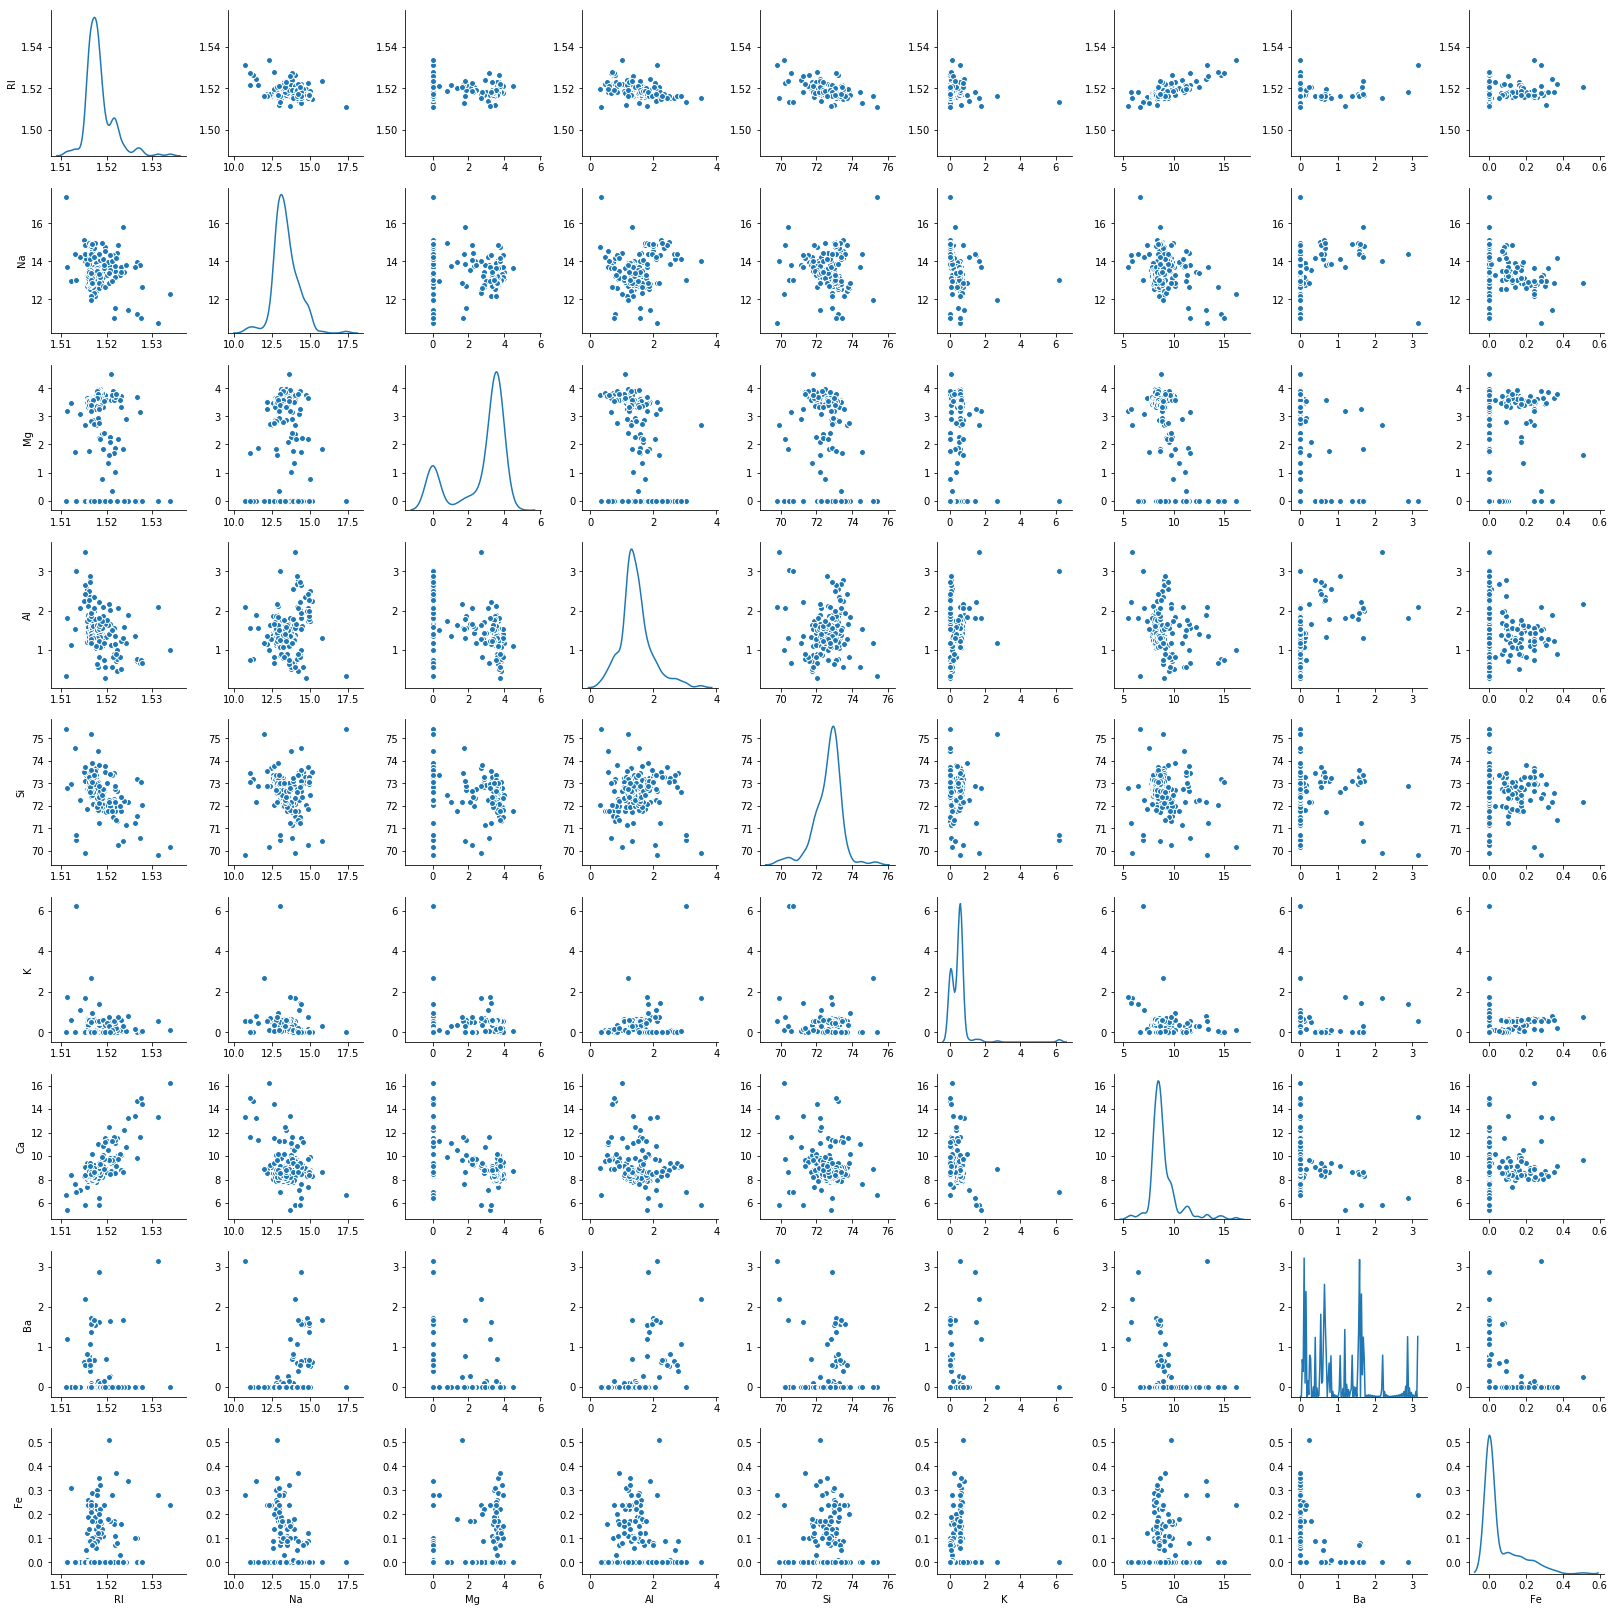

In [105]:
sns.pairplot(data, diag_kind='kde')

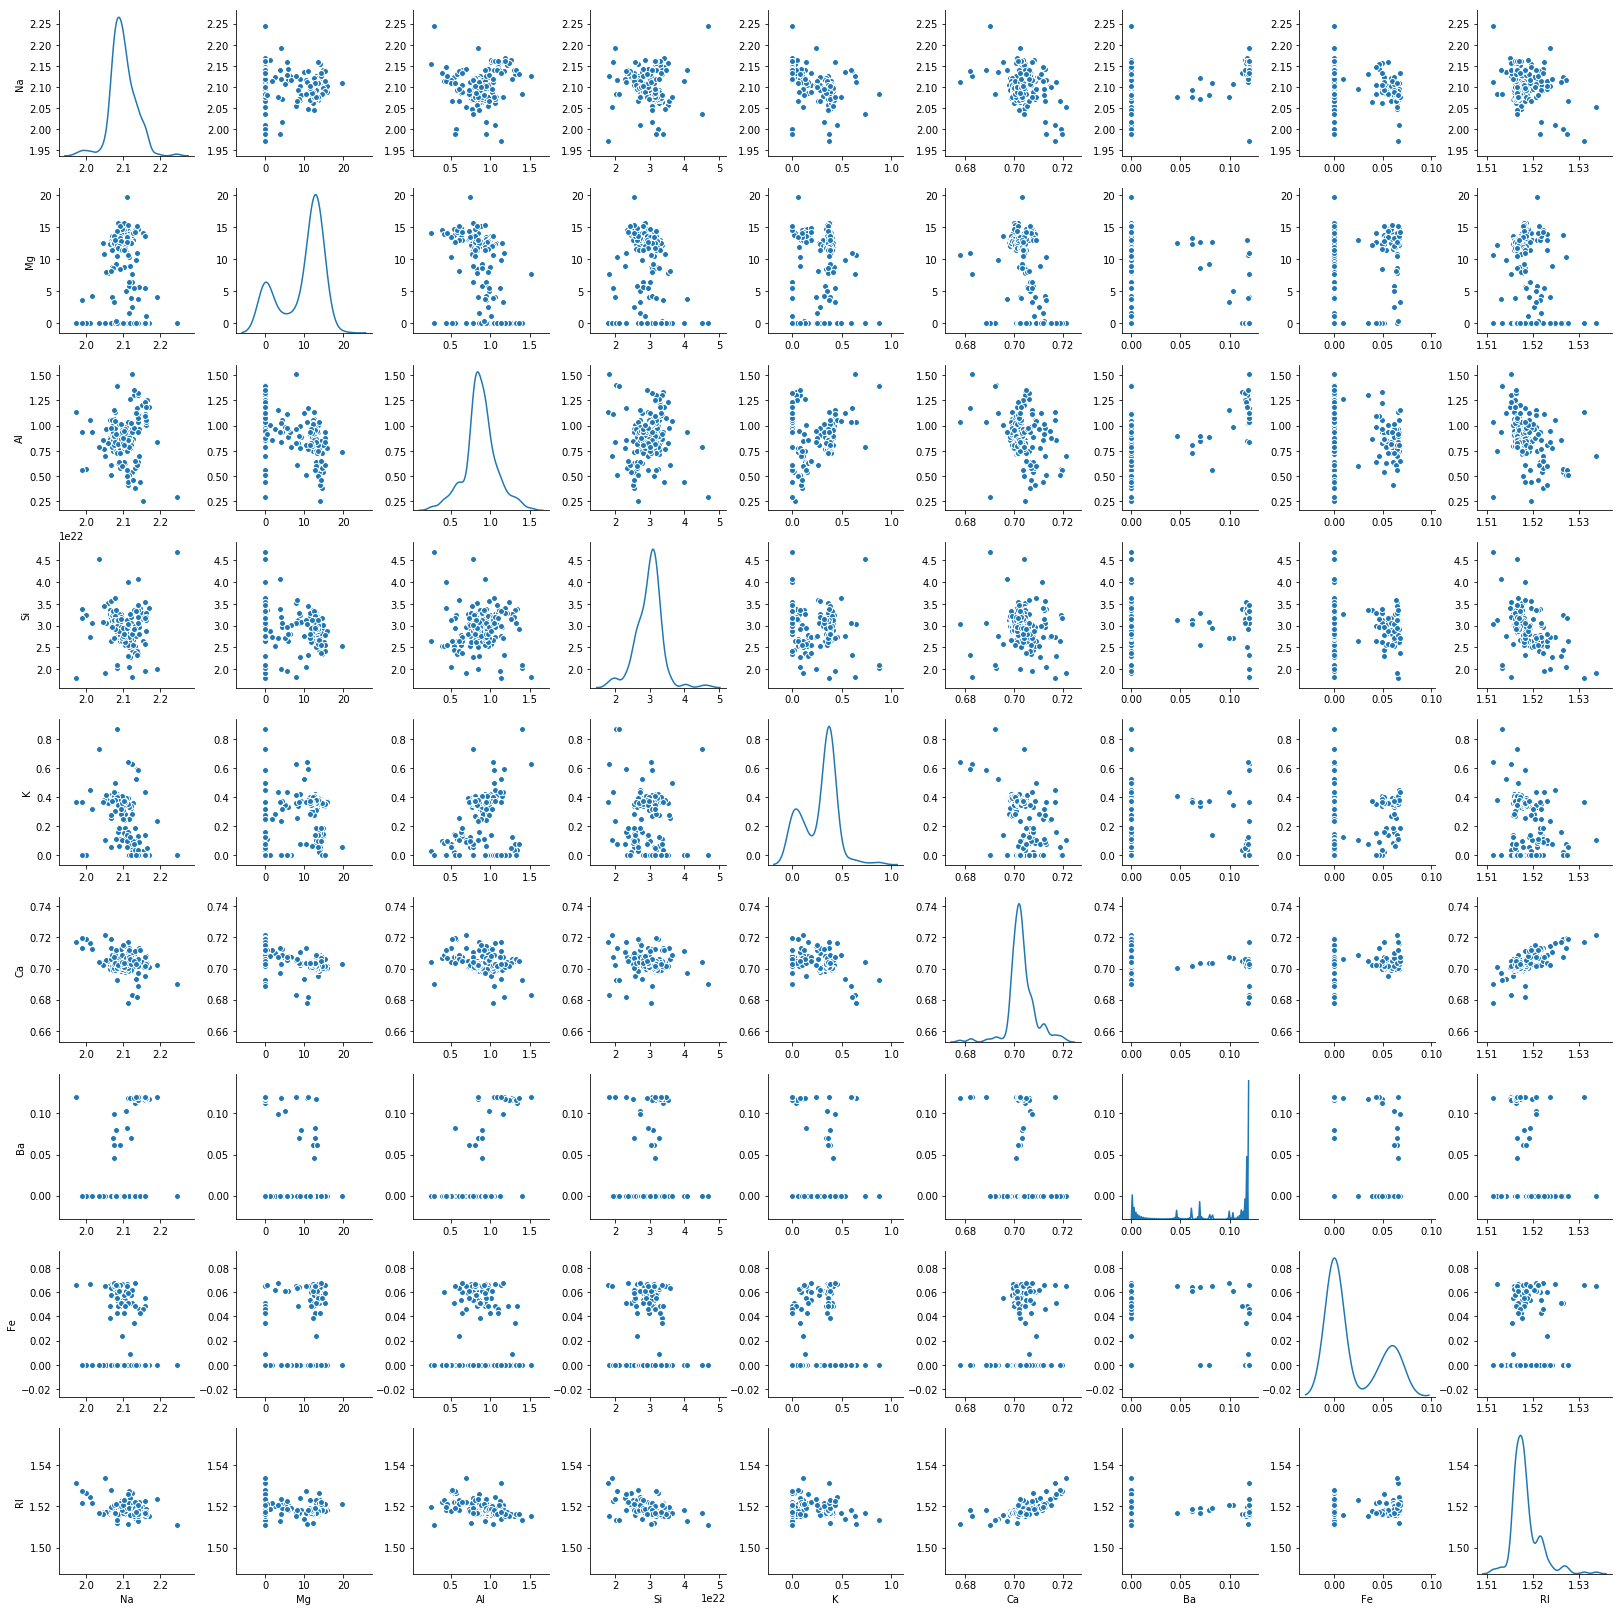

In [106]:
sns.pairplot(data_boxcox, diag_kind='kde')

In [113]:
np.linalg.norm(data.values, axis=1, keepdims=True).shape

(214, 1)

In [114]:
class SpatialSign(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X / np.linalg.norm(X, axis=1, keepdims=True)

In [116]:
sc = StandardScaler()
ss = SpatialSign()

In [117]:
data_spatial = ss.fit_transform(sc.fit_transform(data_boxcox.values))

In [118]:
data_spatial = pd.DataFrame(data_spatial, index=data_boxcox.index, columns=data_boxcox.columns)

In [119]:
data_spatial.describe()

,Na,Mg,Al,Si,K,Ca,Ba,Fe,RI
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,-0.050962,0.115091,-0.025190,0.015895,0.076978,-0.043371,-0.089997,-0.034526,-0.052101
std,0.305973,0.342067,0.295760,0.301726,0.336107,0.286402,0.304769,0.451583,0.295013
min,-0.766429,-0.637433,-0.758787,-0.670753,-0.744519,-0.747470,-0.422596,-0.631739,-0.682229
25%,-0.294468,-0.247741,-0.250782,-0.218824,-0.277018,-0.258374,-0.275670,-0.409057,-0.255765
50%,-0.049607,0.268613,-0.031413,0.060930,0.250428,-0.062588,-0.204284,-0.197032,-0.120026
75%,0.177476,0.369242,0.183267,0.246896,0.338945,0.159823,-0.110942,0.408689,0.122422
max,0.578672,0.690174,0.593554,0.723166,0.587067,0.712088,0.797354,0.846527,0.796346


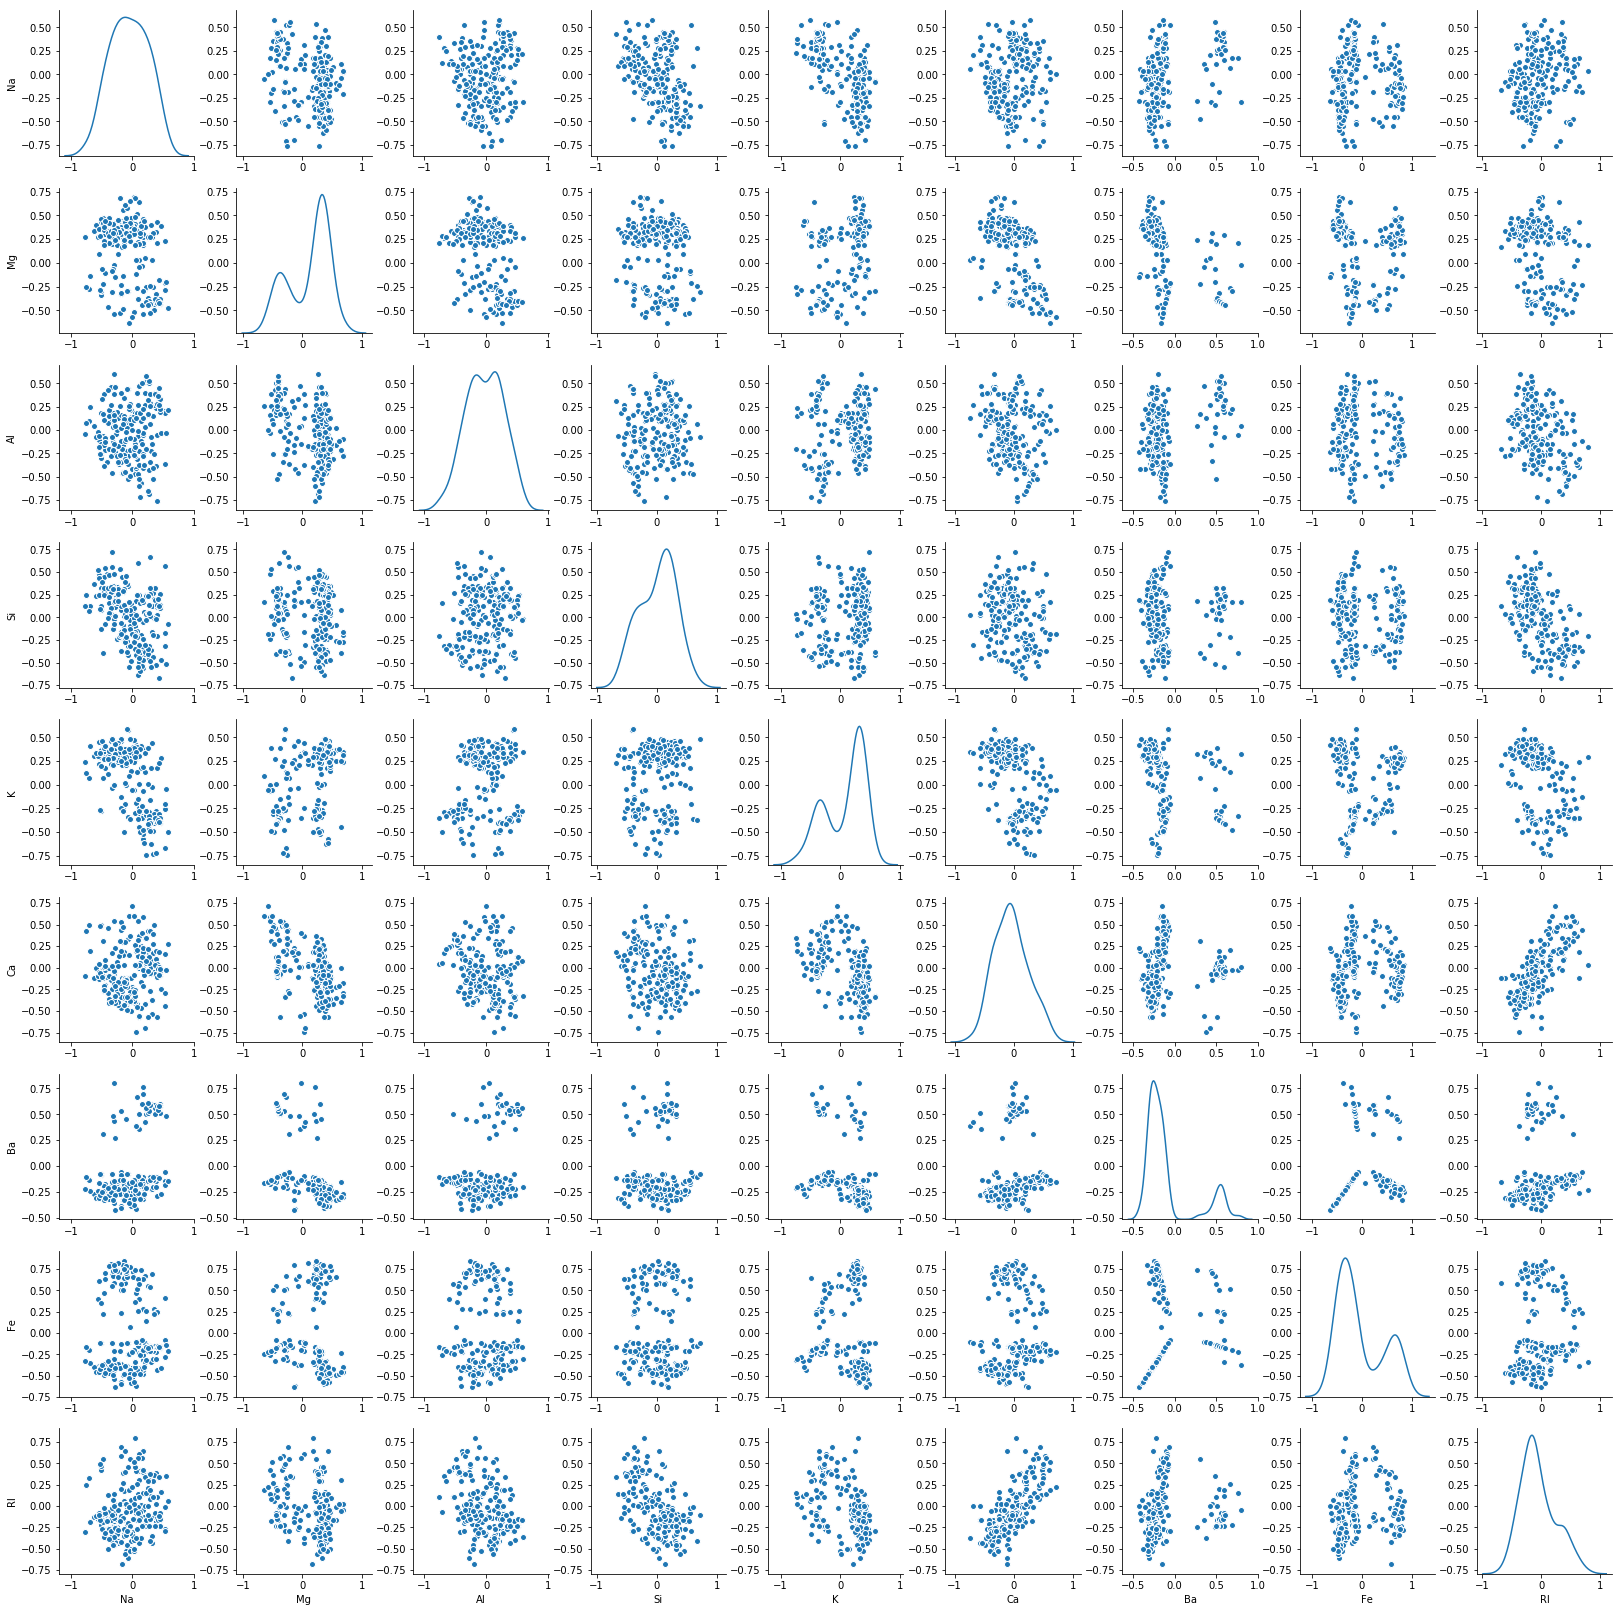

In [120]:
sns.pairplot(data_spatial, diag_kind='kde')

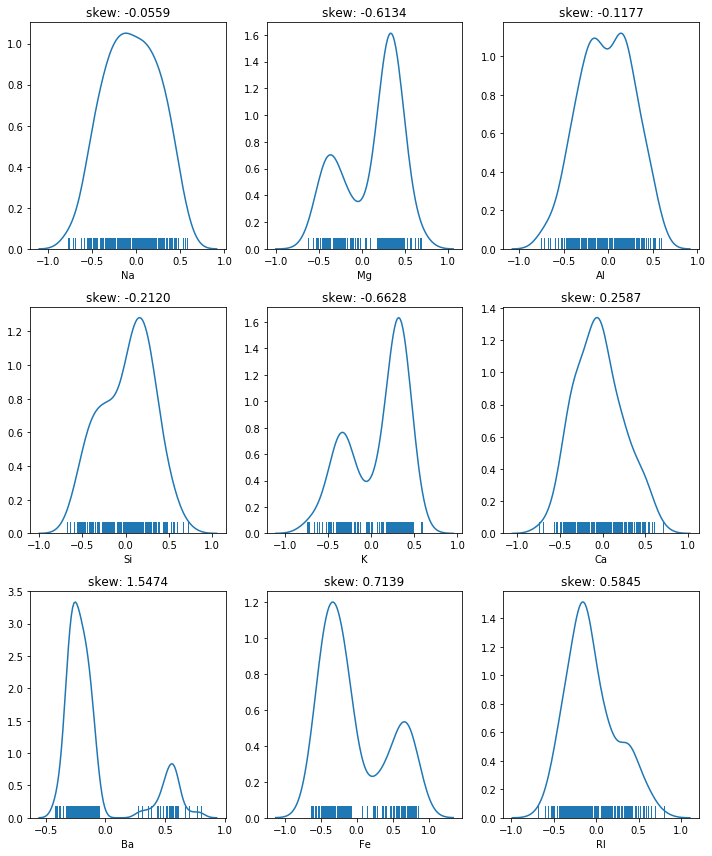

In [123]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 12))

for c, axi in zip(data_spatial.columns, ax.flat):
    sns.distplot(data_spatial[c], hist=False, kde=True, rug=True, ax=axi)
    axi.set_title("skew: {:.4f}".format(skew(data_spatial[c])))
fig.tight_layout()

### Ex 3.2: Soybean

In [281]:
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/soybean/soybean-large.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/soybean/soybean-large.test"

col_names = '''Class date plant_stand precip temp hail crop_hist area_damaged severity seed_tmt germination plant_growth leaves leafspots_halo leafspots_marg leafspot_size leaf_shread leaf_malf leaf_mild stem lodging stem_cankers canker_lesion fruiting_bodies external_decay mycelium int_discolor sclerotia fruit_pods fruit_spots seed mold_growth seed_discolor seed_size shriveling roots'''.split()


In [282]:
soybean = pd.concat([pd.read_csv(train_url, header=None, na_values='?'), 
                     pd.read_csv(test_url, header=None, na_values='?')])
soybean.columns = col_names
soybean.shape

(683, 36)

In [126]:
soybean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 375
Data columns (total 36 columns):
Class              683 non-null object
date               682 non-null float64
plant_strand       647 non-null float64
precip             645 non-null float64
temp               653 non-null float64
hail               562 non-null float64
crop_hist          667 non-null float64
area_damaged       682 non-null float64
severity           562 non-null float64
seed_tmt           562 non-null float64
germination        571 non-null float64
plant_growth       667 non-null float64
leaves             683 non-null int64
leafspots_halo     599 non-null float64
leafspots_marg     599 non-null float64
leafspot_size      599 non-null float64
leaf_shread        583 non-null float64
leaf_malf          599 non-null float64
leaf_mild          575 non-null float64
stem               667 non-null float64
lodging            562 non-null float64
stem_cankers       645 non-null float64
canker_lesion     

In [128]:
df = soybean.describe().T
df['unique'] = [soybean[c].nunique() for c in df.index]
df

,count,mean,std,min,25%,50%,75%,max,unique
date,682.0,3.554252,1.694117,0.0,2.0,4.0,5.0,6.0,7
plant_strand,647.0,0.452859,0.498158,0.0,0.0,0.0,1.0,1.0,2
precip,645.0,1.596899,0.686147,0.0,1.0,2.0,2.0,2.0,3
temp,653.0,1.182236,0.628214,0.0,1.0,1.0,2.0,2.0,3
hail,562.0,0.225979,0.418598,0.0,0.0,0.0,0.0,1.0,2
crop_hist,667.0,1.884558,0.975766,0.0,1.0,2.0,3.0,3.0,4
area_damaged,682.0,1.580645,1.074374,0.0,1.0,1.0,3.0,3.0,4
severity,562.0,0.733096,0.597028,0.0,0.0,1.0,1.0,2.0,3
seed_tmt,562.0,0.519573,0.612241,0.0,0.0,0.0,1.0,2.0,3
germination,571.0,1.049037,0.790988,0.0,0.0,1.0,2.0,2.0,3


In [129]:
pd.crosstab(soybean.temp, soybean.date)

date,0.0,1.0,2.0,3.0,4.0,5.0,6.0
temp,,,,,,,
0.0,9,14,17,16,12,5,7
1.0,11,43,47,78,83,76,36
2.0,3,16,24,16,29,66,45


In [177]:
temp_map = pd.Series(['low', 'norm', 'high', 'missing'], index=[0, 1, 2, np.nan])
temp_map

 0.0        low
 1.0       norm
 2.0       high
NaN     missing
dtype: object

In [142]:
date_map = pd.Series("april,may,june,july,august,september,october,missing".split(','), 
                     index=np.sort(soybean.date.unique()))
date_map

 0.0        april
 1.0          may
 2.0         june
 3.0         july
 4.0       august
 5.0    september
 6.0      october
NaN       missing
dtype: object

In [143]:
soybean.date.map(date_map).value_counts()

september    149
august       131
july         118
june          93
october       90
may           75
april         26
missing        1
Name: date, dtype: int64

In [146]:
precip_map = pd.Series("low,norm,high,missing".split(','), 
                       index=np.sort(soybean.precip.unique()))
precip_map

 0.0        low
 1.0       norm
 2.0       high
NaN     missing
dtype: object

In [147]:
soybean.precip.map(precip_map).value_counts()

high       459
norm       112
low         74
missing     38
Name: precip, dtype: int64

In [178]:
soybean['date'] = soybean.date.map(date_map)
soybean['temp'] = soybean.temp.map(temp_map)

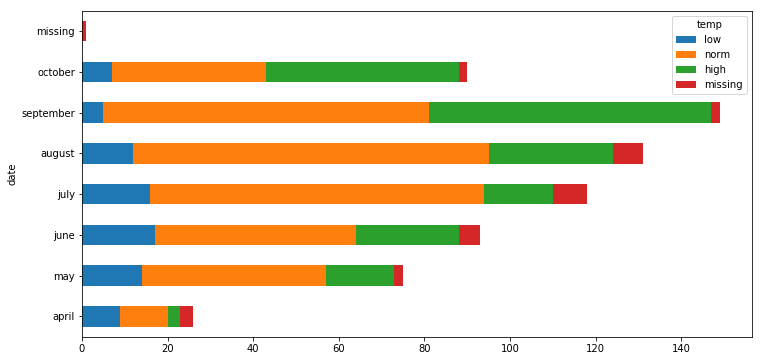

In [175]:
soybean.groupby(['date', 'temp']).size().unstack().loc[date_map.values, temp_map.values].plot.barh(stacked=True, figsize=(12, 6))

In [278]:
col_string = '''1. date:		april,may,june,july,august,september,october,?.
2. plant-stand:	normal,lt-normal,?.
3. precip:		lt-norm,norm,gt-norm,?.
4. temp:		lt-norm,norm,gt-norm,?.
5. hail:		yes,no,?.
6. crop-hist:	diff-lst-year,same-lst-yr,same-lst-two-yrs,same-lst-sev-yrs,?.
7. area-damaged:	scattered,low-areas,upper-areas,whole-field,?.
8. severity:	minor,pot-severe,severe,?.
9. seed-tmt:	none,fungicide,other,?.
10. germination:	90-100%,80-89%,lt-80%,?.
11. plant-growth:	norm,abnorm,?.
12. leaves:		norm,abnorm.
13. leafspots-halo:	absent,yellow-halos,no-yellow-halos,?.
14. leafspots-marg:	w-s-marg,no-w-s-marg,dna,?.
15. leafspot-size:	lt-1/8,gt-1/8,dna,?.
16. leaf-shread:	absent,present,?.
17. leaf-malf:	absent,present,?.
18. leaf-mild:	absent,upper-surf,lower-surf,?.
19. stem:		norm,abnorm,?.
20. lodging:    	yes,no,?.
21. stem-cankers:	absent,below-soil,above-soil,above-sec-nde,?.
22. canker-lesion:	dna,brown,dk-brown-blk,tan,?.
23. fruiting-bodies:	absent,present,?.
24. external_decay:	absent,firm-and-dry,watery,?.
25. mycelium:	absent,present,?.
26. int-discolor:	none,brown,black,?.
27. sclerotia:	absent,present,?.
28. fruit-pods:	norm,diseased,few-present,dna,?.
29. fruit_spots:	absent,colored,brown-w/blk-specks,distort,dna,?.
30. seed:		norm,abnorm,?.
31. mold-growth:	absent,present,?.
32. seed-discolor:	absent,present,?.
33. seed-size:	norm,lt-norm,?.
34. shriveling:	absent,present,?.
35. roots:		norm,rotted,galls-cysts,?.'''

col_string = col_string.replace('-', '_')
col_string = col_string.replace('?', 'missing')

In [283]:
col_mapper = dict()
for line in col_string.split('\n'):
    #print(line)
    head, tail = line.split(':')
    key = head.split()[1].strip()
    val = tail[:-1].strip().split(',')
    
    if val[-1] == 'missing':
        # has NaN
        v = pd.Series(val, index=list(range(len(val[:-1]))) + [np.nan])
    else:
        v = pd.Series(val, index=list(range(len(val))))
    col_mapper[key] = v
    

In [284]:
soybean_cat = soybean.copy()
for k, v in col_mapper.items():
    if k in soybean.columns:
        soybean_cat[k] = soybean_cat[k].map(v)

In [285]:
soybean_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 375
Data columns (total 36 columns):
Class              683 non-null object
date               683 non-null object
plant_stand        683 non-null object
precip             683 non-null object
temp               683 non-null object
hail               683 non-null object
crop_hist          683 non-null object
area_damaged       683 non-null object
severity           683 non-null object
seed_tmt           683 non-null object
germination        683 non-null object
plant_growth       683 non-null object
leaves             683 non-null object
leafspots_halo     683 non-null object
leafspots_marg     683 non-null object
leafspot_size      683 non-null object
leaf_shread        683 non-null object
leaf_malf          683 non-null object
leaf_mild          683 non-null object
stem               683 non-null object
lodging            683 non-null object
stem_cankers       683 non-null object
canker_lesion      683 non-null objec

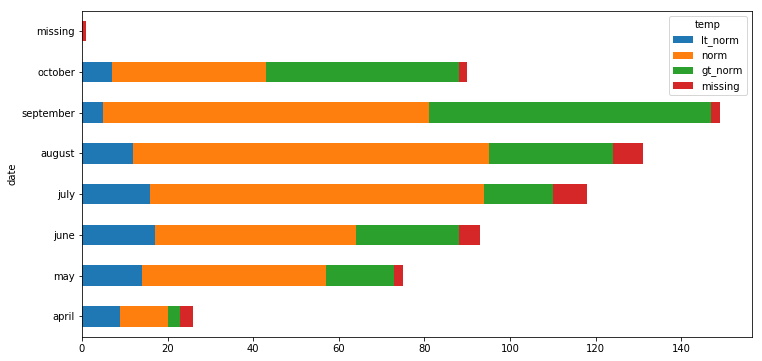

In [221]:
soybean.groupby(['date', 'temp']).size().unstack().loc[col_mapper['date'].values, col_mapper['temp'].values].plot.barh(stacked=True, figsize=(12, 6))

In [230]:
def cat_cat_plot(data, col1, col2, ax=None):
    assert col1 in data.columns
    assert col2 in data.columns
    ax = ax or plt.gca()
    data.groupby([col1, col2]).size().unstack().loc[col_mapper[col1].values, 
                                                    col_mapper[col2].values].plot.barh(stacked=True, ax=ax)

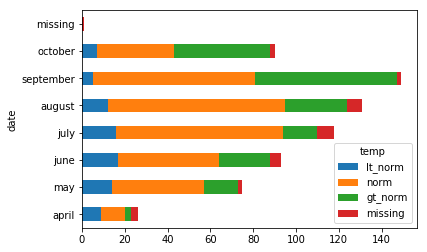

In [231]:
cat_cat_plot(soybean, 'date', 'temp')

In [241]:
soybean.replace('missing', np.nan, inplace=True)

In [261]:
df = soybean[['Class']].copy()
df['has_null'] = (soybean.isnull().sum(axis=1) > 0).astype(int).values
df['no_null'] = (soybean.isnull().sum(axis=1) == 0).astype(int).values

In [265]:
null_class = list(set(df.Class[df['has_null'] > 0]))
null_class

['phytophthora-rot',
 'diaporthe-pod-&-stem-blight',
 '2-4-d-injury',
 'herbicide-injury',
 'cyst-nematode']

In [255]:
df.groupby('Class').sum()

,has_null,no_null
Class,,
2-4-d-injury,16,0
alternarialeaf-spot,0,91
anthracnose,0,44
bacterial-blight,0,20
bacterial-pustule,0,20
brown-spot,0,92
brown-stem-rot,0,44
charcoal-rot,0,20
cyst-nematode,14,0


In [268]:
df = soybean.isnull().astype(int)
df['Class'] = soybean['Class']

In [269]:
df.groupby('Class').mean().T[null_class]

Class,phytophthora-rot,diaporthe-pod-&-stem-blight,2-4-d-injury,herbicide-injury,cyst-nematode
date,0.000000,0.0,0.0625,0.0,0.0
plant_stand,0.000000,0.4,1.0000,0.0,1.0
precip,0.000000,0.0,1.0000,1.0,1.0
temp,0.000000,0.0,1.0000,0.0,1.0
hail,0.772727,1.0,1.0000,1.0,1.0
crop_hist,0.000000,0.0,1.0000,0.0,0.0
area_damaged,0.000000,0.0,0.0625,0.0,0.0
severity,0.772727,1.0,1.0000,1.0,1.0
seed_tmt,0.772727,1.0,1.0000,1.0,1.0
germination,0.772727,0.4,1.0000,1.0,1.0


In [293]:
df = pd.get_dummies(soybean['date'], prefix='date')
df.head()

,date_0.0,date_1.0,date_2.0,date_3.0,date_4.0,date_5.0,date_6.0
0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1


In [294]:
np.var(df.values, axis=0)

array([ 0.03661823,  0.0977515 ,  0.11762335,  0.1429187 ,  0.1550133 ,
        0.17056351,  0.11440784])

In [296]:
[df[c].nunique() / len(df) * 100 for c in df.columns]

[0.29282576866764276,
 0.29282576866764276,
 0.29282576866764276,
 0.29282576866764276,
 0.29282576866764276,
 0.29282576866764276,
 0.29282576866764276]

In [301]:
a, b = df['date_0.0'].value_counts().sort_values(ascending=False).values
a/b

25.26923076923077

### Ex 3.3

In [302]:
data = pd.read_csv('data/BloodBrain/bbbDescr.csv', index_col=0)
outcome = pd.read_csv('data/BloodBrain/logBBB.csv', index_col=0)
outcome.columns = ['target']

In [303]:
data.head()

,tpsa,nbasic,negative,vsa_hyd,a_aro,weight,peoe_vsa.0,peoe_vsa.1,peoe_vsa.2,peoe_vsa.3,...,scaa3,ctdh,ctaa,mchg,achg,rdta,n_sp2,n_sp3,o_sp2,o_sp3
1,12.030000,1,0,167.06700,0,156.293,76.94749,43.44619,0.00000,0.000000,...,-0.0093,1,1,0.9241,0.9241,1.0000,0.000000,6.0255,0.000000,0.000000
2,49.330002,0,0,92.64243,6,151.165,38.24339,25.52006,0.00000,8.619013,...,-0.0754,2,2,1.2685,1.0420,1.0000,0.000000,6.5681,32.010201,33.613499
3,50.529999,1,0,295.16700,15,366.485,58.05473,124.74020,21.65084,8.619013,...,-0.0303,1,4,1.2562,1.2562,0.2500,26.973301,10.8567,0.000000,27.545099
4,37.389999,0,0,319.11220,15,382.552,62.23933,124.74020,13.19232,21.785640,...,-0.0240,1,3,1.1962,1.1962,0.3333,21.706499,11.0017,0.000000,15.131600
5,37.389999,1,0,299.65800,12,326.464,74.80064,118.04060,33.00190,0.000000,...,-0.0255,1,3,1.2934,1.2934,0.3333,24.206100,10.8109,0.000000,15.133300


In [308]:
set(data.dtypes.values)

{dtype('int64'), dtype('float64')}

In [320]:
nz_var = np.var(data.values, axis=0) < .01

In [321]:
nzv = data.columns[nz_var]

In [312]:
def freq_ratio(series):
    s = pd.value_counts(series).sort_values(ascending=False).values
    return s[0]/s[1]

In [314]:
high_freq = np.array([freq_ratio(data[c]) for c in data.columns]) > 20

In [317]:
hfv = data.columns[high_freq]

In [318]:
set(nzv) & set(hfv)

{'alert', 'frac.anion7.', 'negative', 'sadh3'}

In [322]:
nzv

Index(['negative', 'alert', 'tcsa', 'tcnp', 'ovality', 'fpsa1', 'fpsa3',
       'fnsa1', 'fnsa3', 'rpcg', 'rncg', 'sadh3', 'chdh3', 'scdh3', 'saaa3',
       'chaa3', 'scaa3'],
      dtype='object')

In [324]:
data.a_acid.value_counts()

0    201
2      6
3      1
Name: a_acid, dtype: int64

In [338]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

In [343]:
sc = StandardScaler()
vt = VarianceThreshold(threshold=.05)

In [348]:
data_vt = vt.fit_transform(data.values)

In [349]:
data_vt.shape

(208, 112)

In [350]:
data.shape

(208, 134)

In [355]:
select1 = data.columns[vt.get_support()]
len(select1)

112

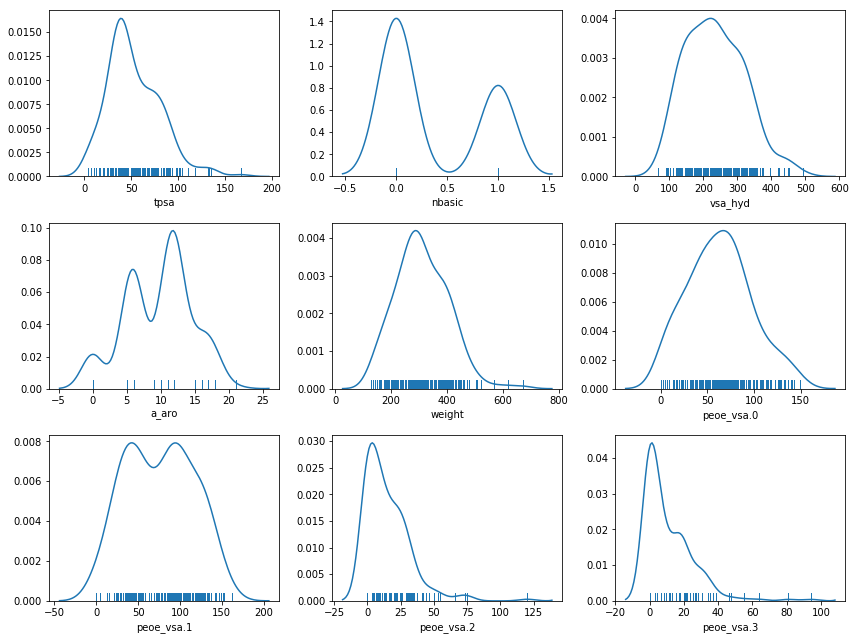

In [354]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

for axi, c in zip(ax.flat, select1[:9]):
    sns.distplot(data[c], hist=False, rug=True, kde=True, ax=axi)
fig.tight_layout()

In [358]:
(np.abs(skew(data[select1])) > 1).sum()

57

In [359]:
data[select1[:9]].min()

tpsa            3.24000
nbasic          0.00000
vsa_hyd        65.44252
a_aro           0.00000
weight        129.20700
peoe_vsa.0      0.00000
peoe_vsa.1      0.00000
peoe_vsa.2      0.00000
peoe_vsa.3      0.00000
dtype: float64

In [361]:
mp = DataFrameMapper(gen_features(select1[:9], classes=[BoxCoxTransformer]), input_df=True, df_out=True)

In [362]:
d2 = mp.fit_transform(data[select1[:9]])

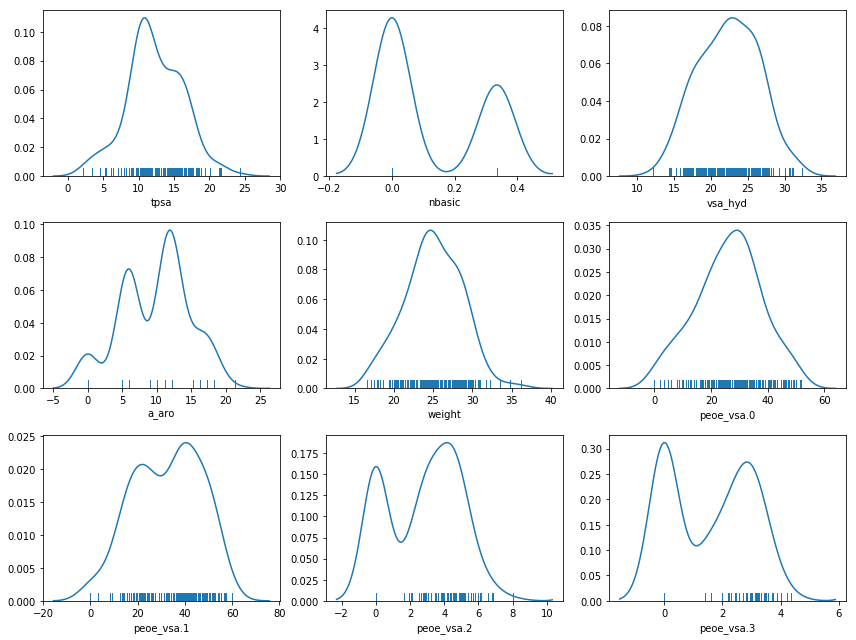

In [363]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12, 9))
for axi, c in zip(ax.flat, d2.columns):
    sns.distplot(d2[c], hist=False, kde=True, rug=True, ax=axi)
fig.tight_layout()

In [376]:
valid_boxcox = data.columns[data.min() > 0]

In [377]:
bx = DataFrameMapper(gen_features(valid_boxcox, classes=[BoxCoxTransformer]), df_out=True, input_df=True)

In [387]:
sp = SpatialSign()

In [388]:
data_select = data[valid_boxcox]
data_bx = bx.fit_transform(data_select)

data_spatial = sp.fit_transform(sc.fit_transform(data_bx))
data_spatial = pd.DataFrame(data_spatial, index=data_bx.index, columns=data_bx.columns)

In [389]:
corr_before = data_select.corr()
corr_after = data_bx.corr()
corr_spatial = data_spatial.corr()

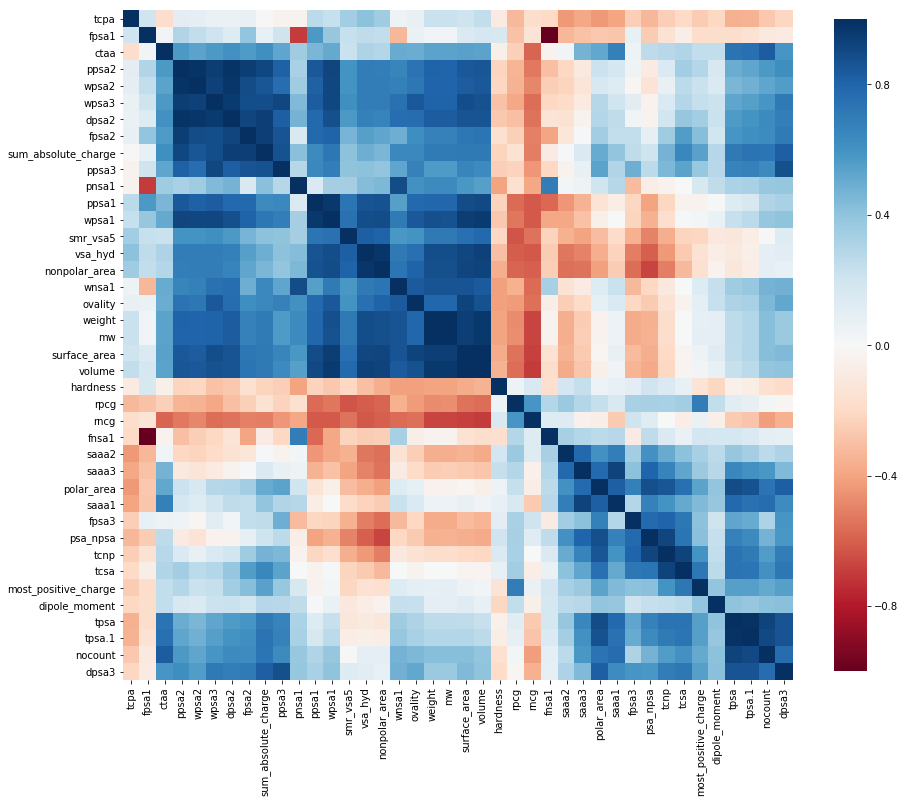

In [382]:
Y = linkage(corr_before, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']
corr_before = corr_before.iloc[:, Z]
corr_before = corr_before.iloc[Z, :]

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_before, square=True, annot=False, 
            xticklabels=True, yticklabels=True, ax=ax, cbar_kws={'shrink':.8}, cmap=plt.cm.RdBu)

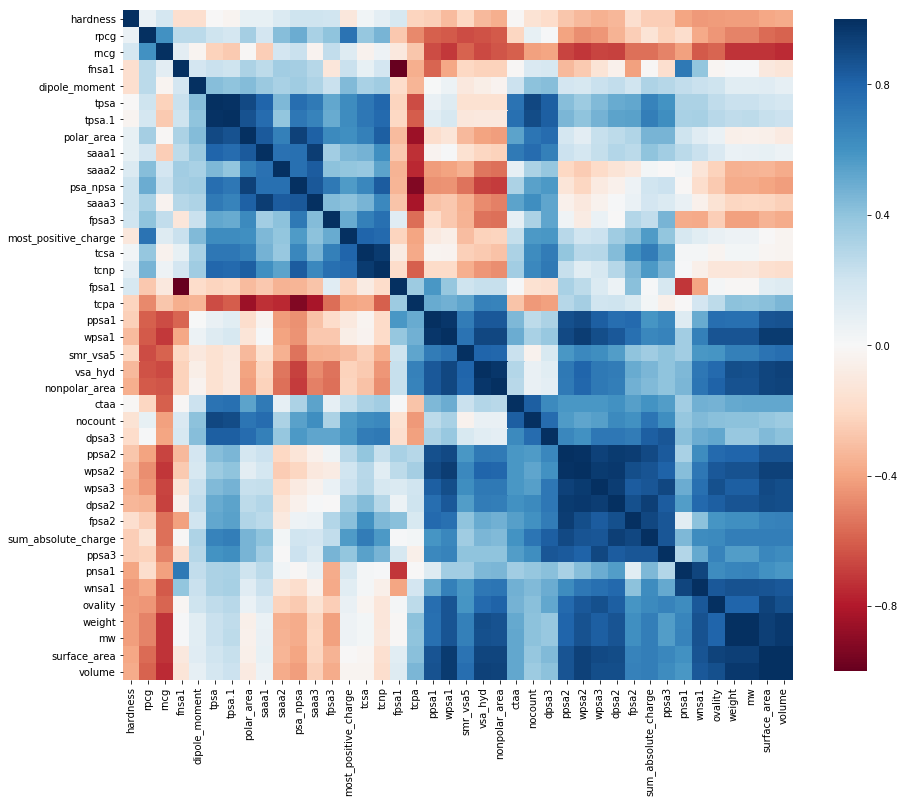

In [383]:
Y = linkage(corr_after, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']
corr_after = corr_after.iloc[:, Z]
corr_after = corr_after.iloc[Z, :]

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_after, square=True, annot=False, 
            xticklabels=True, yticklabels=True, ax=ax, cbar_kws={'shrink':.8}, cmap=plt.cm.RdBu)

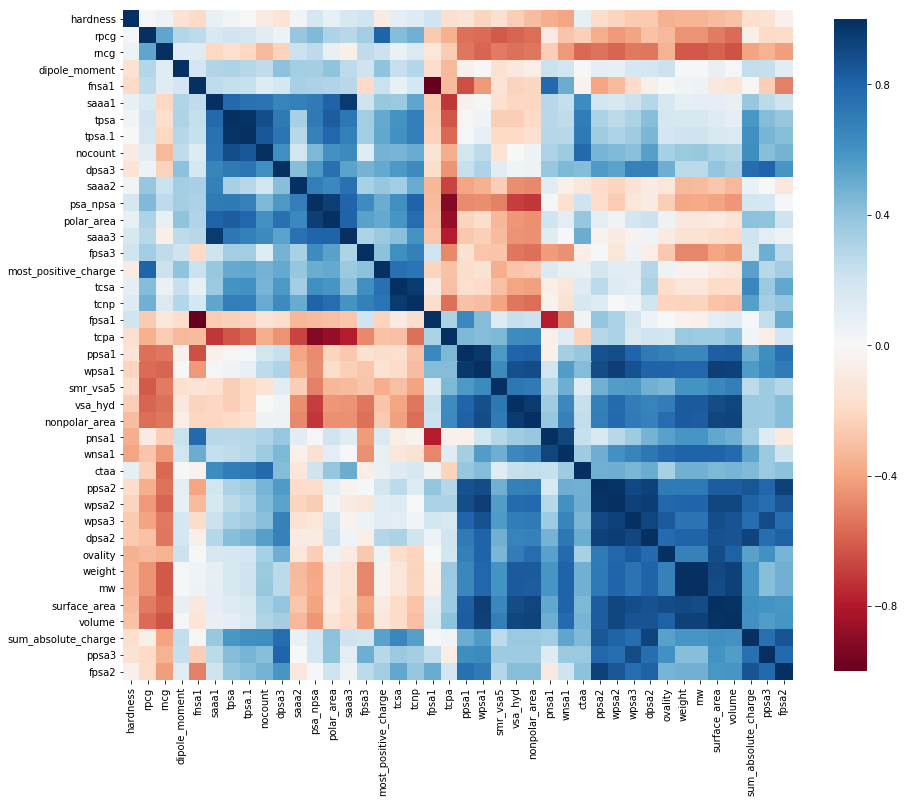

In [390]:
Y = linkage(corr_spatial, method='complete', metric='correlation')
Z = dendrogram(Y, no_plot=True)['leaves']
corr_spatial = corr_spatial.iloc[:, Z]
corr_spatial = corr_spatial.iloc[Z, :]

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_spatial, square=True, annot=False, 
            xticklabels=True, yticklabels=True, ax=ax, cbar_kws={'shrink':.8}, cmap=plt.cm.RdBu)

In [393]:
corr_before.abs().mean().mean(), corr_after.abs().mean().mean(), corr_spatial.abs().mean().mean()

(0.43773507670288236, 0.45439075722421973, 0.41539089759146874)

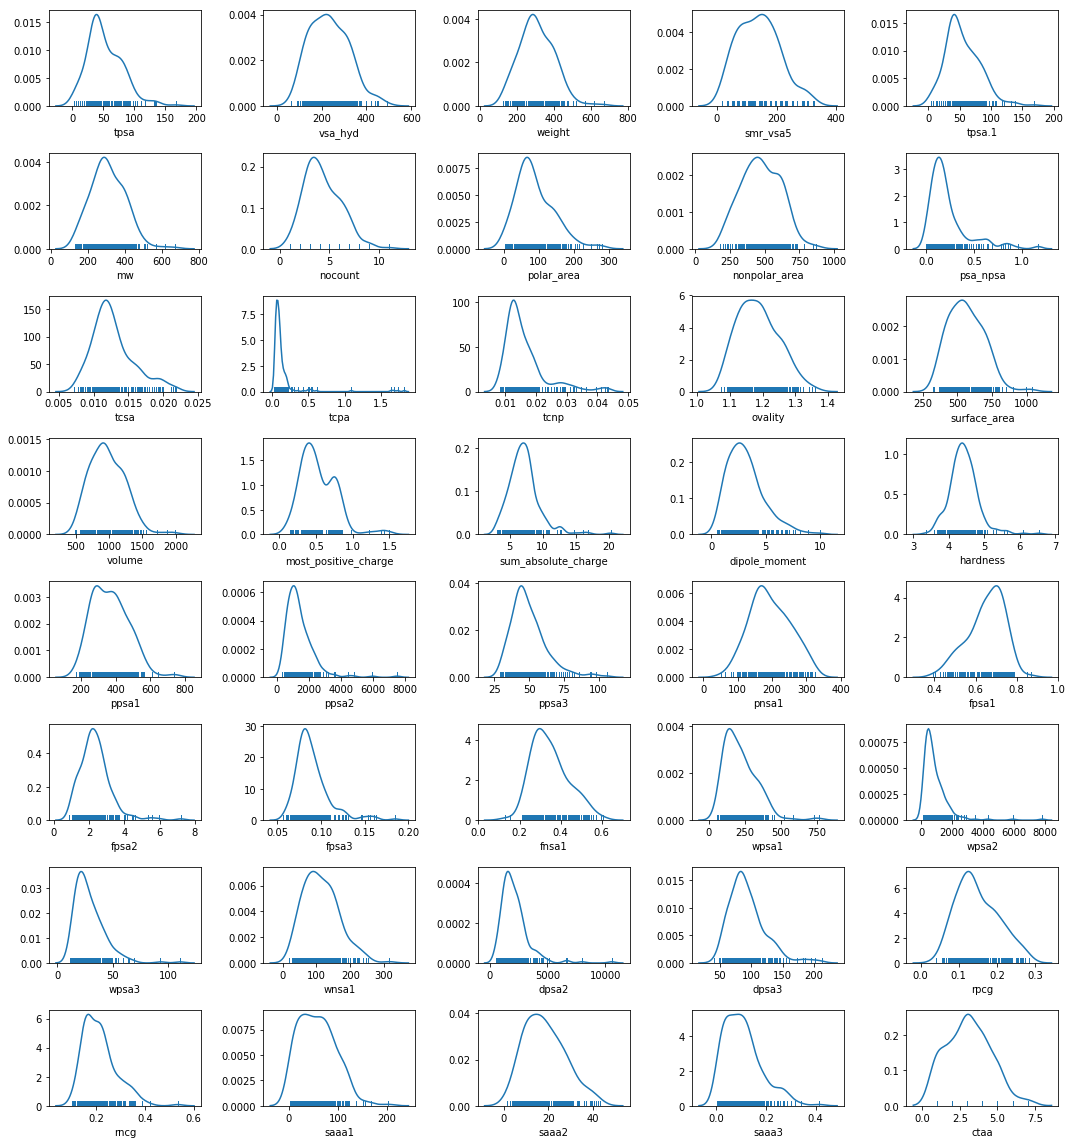

In [385]:
fig, ax = plt.subplots(ncols=5, nrows=8, figsize=(15, 16))
for axi, c in zip(ax.flat, data_select.columns):
    sns.distplot(data_select[c], hist=False, kde=True, rug=True, ax=axi)
fig.tight_layout()

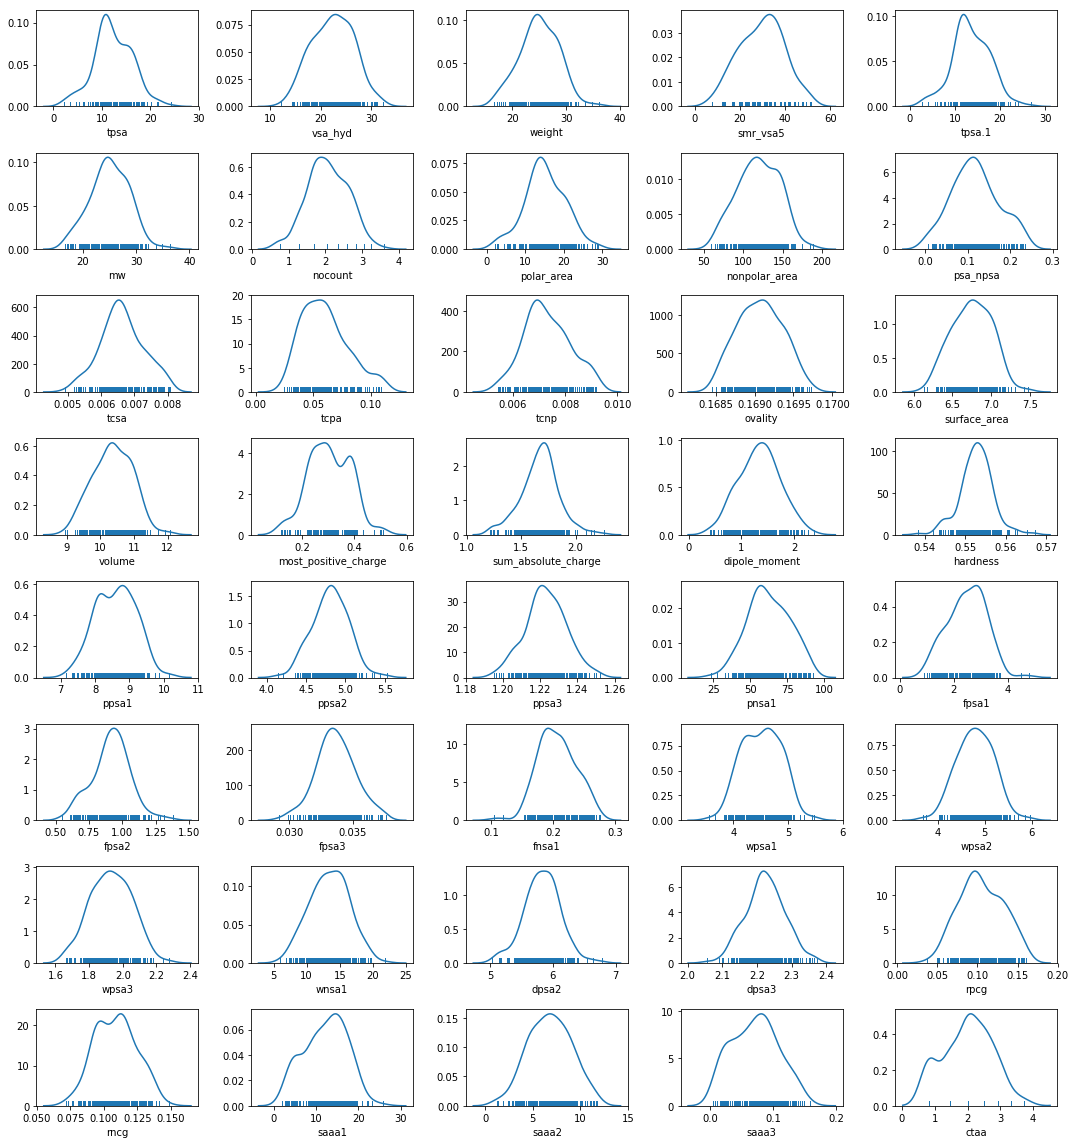

In [386]:
fig, ax = plt.subplots(ncols=5, nrows=8, figsize=(15, 16))
for axi, c in zip(ax.flat, data_bx.columns):
    sns.distplot(data_bx[c], hist=False, kde=True, rug=True, ax=axi)
fig.tight_layout()